### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions (that is artificially scale down the data)
- Fit delay model to simulated delayed data
- Generate nowcasts for t0=90..100
- Retrain process model on mean predicted nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE

### Notation 

We define $y_t$ as an observed value of this incidence in time interval $t$ from our time series $\{y_1, y_2, y_3, \dots\, y_t, \dots, y_T\}$.
We assume that these observations are draws from random variables $Y_1, Y_2, Y_3, \dots, Y_t, \dots, Y_T$, whose probability distributions can be thought of as a function of $t$, prior values of $y$ represented as $y_{1:t}$, and other covariates $x_t$.
We use $T$ throughout to refer to the total number of time points in the time-series and $t$ to refer to a specific time point relative to which a forecast is generated.


For forecasts of the time-series values itself, \ie when a target is defined to be a past or future value of the time-series $Y_{t+k}$, we use a special nomenclature, referring to them as `k-step-ahead` forecasts.  
We define $Z_{i|t}$ as a random variable for target $i$ positioned relative to time $t$. For example, in the infectious disease context, $Z_{i|t}$ could be:

 - incidence at time $t$, or $Y_t$,
 - incidence at time $t+k$ either in the future or past relative to time $t$, or $Y_{t+k}$, where $k$ is a positive or negative integer,
 - peak incidence within some period of time or season, or $\max_t (Y_t)$ where $t$ are defined to be within a season,
    \item the time at which a peak occurs within some season, or $\{ t': Y_{t'} = \max_t (Y_t) \} $
 - a binary indicator of whether incidence at time $t+k$ is above a specified threshold $C$, or $\mathds{1} \{Y_{t+k}>C\}$.
\end{itemize}


A forecast must provide {\em quantitative and probabilistic} information about an outcome.
In the context of this notation, a forecast can be represented as a predictive density function for a target, or $f_{z_{i|t}}(z|y_{1:t}, t, x_{t})$.
The form of this density function will depend on the type of variable that $Z$ is, and it could be derived from a known parametric distribution or specified directly.

In our initial experiments we are mostly concerned with the following distribution

$$f_{Y_{t+k}|i}(Y_t | y_{1:t},t,x_t)$$

that is, $k-step$ ahead forecast relative to time $t$.


To enable clear definitions for forecasting in real-time, forecasts must be associated with a specific time $t$.
In our database infrastructure, we refer to this time as a {\tt timezero}.
This specific time $t$ represents the point relative to which targets are defined.
For example, if a forecast is associated with week 45 in 2013, then a `1-step-ahead' forecast would be associated with incidence in week 46 of 2013 and a `3-step-ahead' forecast would be associated with week 48.
This {\tt timezero} is not an intrinsic feature of a project or dataset, and is more or less arbitrarily defined or named by the data analyst or project organizers.
For example, in the project above, if we defined a timezero as week 44 in 2013 then a `2-step-ahead' forecast would be associated with incidence in week 46, same as a `1-week-ahead' forecast from week 45.

However, a second important date further refines our notion of what constitutes a forecast. 
We define a date $d$ as a {\tt data-version-date}. 
Taken together, a $(t,d)$ pair uniquely define a forecast setting.
Specifically, a forecast for $(t,d)$ represents forecasts for targets relative to date $t$ using data available at date $d$. 

## Simulation Study, fixing delay proportions and generating nowcast

In order to apply the delay we simply take 

$$N_{t,d} = \sum_{i=0}^dp_i*N_{t,\infty}$$

## Using nowcast to improve forecast




In [2]:
from scipy.special import expit
import numpy as np
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

scale_factor =1 
variance_level_results = []

cutoff = 50
D = 10


arr_list = np.zeros(260)
        # iterate over season  
for s in range(10):
        #iterate over biweek per season
        for t in range(26):
            season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[(s-1)*26+t] = np.random.poisson(e_y) 

ts = arr_list[:cutoff]

for var in np.arange(0,100,10):
    rmse_vec = []
    

    for sim in range(100):
        
        # plot simulated data to make sure it looks like ID        

        p_vec = np.random.dirichlet(np.ones(D),size=1)[0]


        p_vec_noise = []

        train_n_t_d = []
        for t in ts:
            tmp_p_vec = expit(p_vec) + np.random.normal(0,var,size=len(p_vec))
            tmp_p_vec = np.exp(tmp_p_vec)/sum(np.exp(tmp_p_vec))
            tmp = np.random.multinomial(t,tmp_p_vec)

            train_n_t_d.append(tmp)


        print (tmp_p_vec)    
        train_n_t_d = np.array(train_n_t_d)
        ts = train_n_t_d.sum(axis=1)


        k = np.array(train_n_t_d).shape[1 ]

        p_vec_noise = np.ones(k)

        for i in range(cutoff-D):
            p_vec_noise += train_n_t_d[i]

        p_vec_noise = p_vec_noise/np.sum(p_vec_noise)


        data_to_be_delayed = train_n_t_d[(cutoff-D):]
        count = len(data_to_be_delayed[0])
        folded_delayed_data = np.zeros(D)
        for i in range(len(data_to_be_delayed)):
            folded_delayed_data[i] = np.sum(data_to_be_delayed[i][:count])
            count -=1

        delayed_data = np.append(ts[:(cutoff-D)],folded_delayed_data)
        n_t_d = data_to_be_delayed

        myDLM = dlm(ts[:(cutoff-D)])
        myDLM = myDLM + seasonality(26, name='26week', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=ts[:(cutoff-D)], name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)


        n_t_inf_hat = predictMean
        num_mc_samples = 1000
        reweighted_trajectory = []
        from  scipy.stats import binom
        from  scipy.stats import norm
        count = D

        for t in range(len(n_t_inf_hat)):
            likelihood_previous = 1e-50
            likelihood_current = 1e-50
            prior_previous = 1e-50
            prior_current = 1e-50
            chain = []
            proposal_mean = 50
            ar = 0
            for s in range(num_mc_samples):

                proposal = np.random.normal(proposal_mean,10)

                prior_current = norm(n_t_inf_hat[t],np.sqrt(predictVar[t])/scale_factor).pdf(proposal)

                likelihood_current = binom.pmf(folded_delayed_data[t],proposal,sum(p_vec_noise[:count]))
                alpha = likelihood_current*prior_current /(likelihood_previous*prior_previous)
                #print (alpha,likelihood_current*prior_current,likelihood_previous*prior_previous)

                if alpha >1 :           
                    likelihood_previous = likelihood_current
                    prior_previous = prior_current
                    proposal_mean = proposal
                    chain.append(proposal_mean)
                    ar += 1
                elif np.random.uniform(0,1) < alpha:
                    #print ("hello")
                    likelihood_previous = likelihood_current
                    prior_previous = prior_current
                    proposal_mean = proposal
                    chain.append(proposal_mean)
                    ar += 1
            if ar/(1.0*num_mc_samples) == 0.0:
                ret = 0
            elif np.isnan(np.mean(chain[200:])):
                ret = 0
            else:
                ret = np.mean(chain[200:])
            reweighted_trajectory.append(ret)


            count -=1 


        #num_mc_samples = 1000
        #reweighted_trajectory = []
        #from  scipy.stats import binom
        #count = 10
        #for t in range(len(n_t_inf_hat)):
         #   likelihood_previous = -100000
          #  likelihood_current = -1000000
          #  tmp = 0
          #  for s in range(num_mc_samples):
                
          #      fcast = np.random.normal(n_t_inf_hat[t],1.0*np.sqrt(predictVar[t])/10 + .0000000001)
          #      likelihood_current = binom.logpmf(folded_delayed_data[t],fcast,sum(p_vec_noise[:count]))
                #print (data_to_be_delayed[t],fcast,sum(p_vec[:count]),likelihood_current)
           #     if likelihood_current > likelihood_previous:           
            #        likelihood_previous = likelihood_current
             #       tmp = fcast
            #print (len(tmp))
            #reweighted_trajectory.append(tmp)

            #count -=1 

        zero_through_90_data = delayed_data[:(cutoff-D)]
        ninety_through_100_data = delayed_data[(cutoff-D):]
        naive_training_data = ninety_through_100_data/np.flip(np.cumsum(p_vec_noise),axis=0)
        naive_training_data_final = np.append(zero_through_90_data,naive_training_data)

        myDLM = dlm(naive_training_data_final)
        myDLM = myDLM + seasonality(26, name='26day', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=naive_training_data_final, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (scale_up_predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)


        new_training_data = np.nan_to_num(np.append(ts[:(cutoff-D)],reweighted_trajectory))
        myDLM = dlm(new_training_data)
        myDLM = myDLM + seasonality(26, name='26day', w=1.0)

        myDLM = myDLM + autoReg(degree=2, data=new_training_data, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMeanRetrain, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)

        truth = arr_list[cutoff:(cutoff+D)]

        from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
        myDLM = dlm(delayed_data)

        myDLM = myDLM + autoReg(degree=2, data=delayed_data, name='ar2', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        (predictMean, predictVar) = myDLM.predictN(N=10, date=myDLM.n-1)
        #plt.plot(range(100,110),predictMeanRetrain,color='b')
        #plt.plot(range(100,110),scale_up_predictMean,color='r')
        #plt.plot(range(100,110),arr_list[100:110],color='y')
        #plt.title("1-10 k step ahead t0 = 100 dvd=100")
        #plt.legend(("Delay Adjusted t0=100, 1-10 step ahead ","Naive Scaleup, t0=100, 1-10 step ahead ","Truth"))
        #plt.xlabel("Time")
        #plt.ylabel("Incidence")

        #plt.show()
        rmse_vec.append(mean_squared_error(predictMeanRetrain,truth)/mean_squared_error(scale_up_predictMean,truth))
        
        
    variance_level_results.append([rmse_vec])
        
        
        

[0.09925704 0.0979634  0.10360513 0.10056065 0.09854882 0.09891167
 0.09957755 0.09782442 0.09883682 0.1049145 ]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


/Users/gcgibson/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gcgibson/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.10025495 0.09776344 0.10416536 0.10212962 0.09859189 0.09915224
 0.10200349 0.09781771 0.09859287 0.09952843]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09765848 0.09844754 0.11167168 0.09921225 0.0983467

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09831299 0.1022866  0.10002968 0.10174461 0.10349688 0.09826289
 0.0982147  0.10112701 0.09765389 0.09887076]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09973001 0.09752119 0.09828177 0.10094901 0.1083390

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.10252281 0.10378207 0.09970067 0.09937298 0.09875171 0.09982828
 0.09901091 0.09981917 0.09908802 0.09812338]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09776908 0.09903644 0.09793253 0.10172933 0.1007486

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09909762 0.0982677  0.10615862 0.09824464 0.09987557 0.09823018
 0.10422694 0.09827005 0.09975546 0.09787323]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09757179 0.10034128 0.09775827 0.10051411 0.1008576

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.10049741 0.10480002 0.10043489 0.09997671 0.09851239 0.098425
 0.09949945 0.09963588 0.0994418  0.09877644]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09845266 0.09767158 0.10022971 0.10041099 0.10349069 

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.10166619 0.10666001 0.09987291 0.09752402 0.09938791 0.09797125
 0.09783727 0.10196234 0.09835462 0.09876349]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09961221 0.09809785 0.10388201 0.09834137 0.0994935

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09820765 0.09928926 0.09949708 0.09916853 0.10287065 0.09996677
 0.09891568 0.10391225 0.09890211 0.09927002]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.09820379 0.09832063 0.10403375 0.097844   0.0981205

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[0.0978327  0.09840449 0.0979979  0.10058181 0.09914107 0.09864812
 0.10984996 0.09903017 0.09907811 0.09943567]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.60971890e-04 9.94970948e-01 1.79115155e-08 6.154494

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[7.69227286e-06 1.52007507e-06 1.98901999e-04 3.30888495e-13
 2.79325017e-10 3.24340037e-03 9.96548201e-01 1.90599271e-07
 9.01985676e-08 3.09761755e-09]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.56340356e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.75809350e-12 2.35132628e-04 2.88552911e-03 2.36016705e-02
 9.71596214e-01 6.14957901e-04 3.13834367e-04 1.80067325e-05
 7.23393401e-05 6.62315290e-04]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.32590265e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.42169023e-07 6.07514950e-01 6.04839589e-05 2.44865142e-13
 8.05444805e-09 2.48946768e-09 2.06109286e-06 1.06879715e-10
 3.35860362e-05 3.92388066e-01]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.03142897e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.93433771e-11 6.81388740e-14 4.03449644e-08 1.47700172e-16
 1.10457306e-07 3.70595700e-02 2.18116968e-02 2.77531772e-08
 9.40990529e-01 1.38025838e-04]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.58578262e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.94305143e-12 1.11034511e-10 1.34649394e-12 1.04806643e-06
 9.42264108e-08 1.86605200e-01 8.07686685e-01 8.27300702e-08
 4.82766285e-04 5.22412324e-03]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.28294098e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.86164486e-06 6.12661553e-15 7.78616363e-15 4.60545588e-01
 1.33636072e-09 2.45313124e-06 2.43365282e-12 3.91967607e-11
 5.39450096e-01 1.40440939e-10]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.09172396e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.37666471e-07 8.70761893e-01 1.13971374e-07 1.17136408e-01
 2.10295202e-05 5.54162484e-11 1.59833584e-09 1.00663574e-05
 1.20699496e-02 8.40349790e-10]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.27858708e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[9.16681284e-08 7.15802534e-13 2.62782787e-09 7.27930093e-21
 9.10784821e-15 2.30314546e-13 5.90392115e-18 1.77414215e-08
 2.05789516e-32 9.99999888e-01]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.17602377e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.94989932e-04 9.99506757e-01 7.22840312e-08 2.07118392e-13
 3.34119677e-05 6.47669062e-05 3.05513411e-10 3.44201244e-12
 1.91529818e-09 3.91054609e-16]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.32365884e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.13126081e-15 4.00755778e-11 2.91057324e-09 4.81546722e-25
 5.63736465e-19 9.99999997e-01 6.32038269e-21 7.36128639e-41
 6.55247070e-37 5.38098389e-18]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.53514010e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.24622246e-21 1.00000000e+00 1.88999888e-25 3.22737376e-31
 6.65433361e-25 5.33552003e-16 4.14882248e-15 3.02287175e-13
 3.18945404e-13 3.50646960e-28]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.18186187e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.36460283e-09 5.56029256e-11 4.91163713e-17 8.32135374e-12
 1.17206626e-11 7.24026243e-30 5.06927707e-12 9.99999953e-01
 9.53169320e-22 4.05660473e-08]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.05102267e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[7.02815102e-24 7.85489878e-23 1.22959879e-09 5.93236361e-29
 1.20784213e-23 2.97361476e-20 1.24141934e-25 5.57933158e-08
 3.25810252e-40 9.99999943e-01]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.83739652e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.96252983e-02 5.11507867e-24 1.38048890e-21 9.80365650e-01
 5.20344848e-19 1.09258926e-13 1.10844273e-13 9.05131474e-06
 6.57863635e-12 1.33544133e-13]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.30116007e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.26595428e-42 1.58206956e-42 4.02185004e-10 3.98128976e-31
 2.66683128e-42 2.28872963e-42 1.33527074e-36 3.73612188e-31
 1.00000000e+00 1.99216527e-59]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.28877053e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.19060553e-05 1.83376819e-04 9.60850023e-12 1.27884764e-11
 9.99784717e-01 1.73136859e-12 2.66010266e-41 1.02314423e-14
 4.79944901e-37 4.26087138e-15]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.27614261e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.02296470e-17 1.58997681e-24 1.00000000e+00 4.05318361e-41
 9.70717151e-13 1.63791442e-27 5.59293888e-32 2.48985168e-48
 3.41367913e-15 5.53649881e-52]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.62015223e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.34796911e-09 2.63985251e-27 3.41716077e-05 9.97557574e-01
 6.64196579e-32 2.56945797e-19 2.18435337e-27 1.21356079e-03
 5.41545639e-26 1.19469257e-03]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.11327317e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.09985917e-17 1.95197093e-19 9.99999997e-01 2.66882714e-32
 2.30592605e-46 6.52946644e-45 9.13694903e-30 1.16625902e-39
 2.98802232e-09 5.07808148e-45]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.85697537e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.57869852e-20 1.24616231e-08 2.33400077e-23 6.87494964e-30
 1.63743360e-19 4.77145277e-03 1.57749586e-12 2.94605567e-23
 2.06832287e-15 9.95228535e-01]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.49310683e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.64862526e-31 3.05359068e-18 4.30330127e-35 2.18993612e-25
 2.06190408e-27 4.91058007e-14 9.99999996e-01 4.70128868e-11
 5.02433183e-23 4.24781537e-09]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.52446429e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.43839357e-40 9.99999985e-01 2.62542871e-18 4.03435268e-44
 3.04022472e-41 6.73141092e-71 6.01537314e-11 4.04288633e-46
 3.85386351e-17 1.52379766e-08]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.53772019e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.55228977e-23 4.70966035e-05 6.69810888e-23 9.99952903e-01
 3.12120549e-48 5.87251098e-46 5.07439827e-29 1.27937230e-29
 1.39589985e-42 1.13766225e-33]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.05116682e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.28635591e-12 1.37971973e-04 1.56398772e-28 1.01826797e-04
 4.52596539e-04 9.99299933e-01 7.67176817e-06 2.43301973e-11
 1.11255078e-52 1.88960863e-36]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.59831190e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.54914111e-33 4.17111361e-19 9.12052430e-02 9.49684905e-24
 1.26423921e-15 3.35814301e-09 1.28086880e-45 6.64634161e-39
 7.43566259e-06 9.08787318e-01]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.79650183e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.29144223e-32 1.47480525e-28 3.19897605e-42 9.19393963e-47
 3.12175516e-09 1.40144228e-05 9.99985982e-01 2.44715281e-32
 9.92702661e-17 2.66572303e-16]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.39671325e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.46727097e-29 5.04775426e-34 1.02589383e-33 1.47231320e-39
 1.00000000e+00 1.16340966e-39 2.37935232e-24 9.62270504e-32
 1.76257796e-45 5.91486853e-37]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.82800725e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.72157017e-27 6.36066080e-45 1.75610576e-51 1.00000000e+00
 2.13317956e-18 1.90176124e-35 1.87562684e-27 7.71389341e-44
 2.35692271e-30 2.91511311e-28]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.17746824e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.93503832e-23 6.11871760e-01 2.21025113e-14 1.46255219e-11
 3.88128222e-01 6.09910121e-33 1.78926260e-08 1.60774740e-10
 2.68250750e-64 8.16704654e-37]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.95479450e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.11935298e-31 1.61258072e-08 2.63684558e-40 1.27379356e-15
 4.18615336e-24 9.99999943e-01 4.11713220e-08 2.25898918e-54
 1.41469094e-22 4.45882129e-59]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.91085040e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[9.99999948e-01 2.96701093e-49 7.60006007e-27 5.92432780e-64
 5.00681750e-08 3.90269819e-12 1.31725535e-09 9.50529254e-10
 3.51372864e-32 9.57457272e-53]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.00000000e+

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.92394072e-34 2.45594495e-59 1.09335037e-51 2.72434741e-72
 1.49166747e-58 9.99990084e-01 9.91616486e-06 1.29938071e-25
 2.12637734e-22 5.34755729e-30]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.97542775e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.87307018e-33 3.40749204e-16 2.31974818e-27 2.82296014e-05
 4.22531865e-17 1.62910410e-20 9.99971770e-01 1.68344228e-13
 3.56560922e-39 1.26756464e-34]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.79279155e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.66710501e-71 3.67469132e-70 2.17661894e-61 1.00000000e+00
 7.17373098e-19 1.36752688e-10 4.51595570e-55 8.82648615e-53
 7.92607990e-36 1.72125583e-53]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.88046167e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.35901645e-48 7.81656236e-26 3.18133523e-60 1.00000000e+00
 3.19386291e-51 4.98609525e-82 5.32301960e-45 1.62650425e-68
 3.58532535e-52 1.86508150e-57]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.00000000e+

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.00000000e+00 1.93003519e-48 7.99912676e-93 7.53939625e-40
 6.39679602e-45 2.37143000e-78 1.37573474e-35 2.46847384e-45
 5.43214342e-65 4.53230297e-53]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.64471550e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.09450916e-28 4.24195586e-06 1.33435674e-12 5.67467697e-04
 2.90376549e-29 2.64805071e-39 4.30190914e-18 3.22891384e-17
 3.58650813e-17 9.99428290e-01]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.93664800e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[7.46183718e-13 3.15094820e-33 3.83989388e-64 1.00000000e+00
 1.90101266e-65 4.53157000e-20 6.88117160e-18 5.81036427e-35
 7.12699596e-62 2.13172332e-91]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.89738415e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.86969565e-28 8.39119666e-48 9.99999990e-01 1.59545619e-20
 1.10251346e-29 7.23547003e-93 6.68115291e-91 1.26970889e-70
 1.00310025e-08 6.95891345e-42]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.66527411e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[9.12027827e-50 9.71338868e-33 1.00000000e+00 3.53367820e-61
 6.04762499e-37 7.43450835e-40 5.44611293e-83 1.12953548e-26
 4.01397123e-70 5.26955590e-16]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.55733017e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.19574696e-020 2.07171642e-030 2.23889497e-064 7.62888910e-026
 1.52687521e-043 5.25684824e-114 2.93784595e-035 1.00000000e+000
 5.53470997e-043 7.36930265e-063]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[9.99994730e-01 6.20973942e-43 1.26622258e-30 1.33376354e-57
 5.26999114e-06 8.67464740e-22 2.73251777e-56 2.50080792e-47
 2.58045292e-24 9.99510573e-43]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.92396368e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[7.37602537e-041 3.03547597e-056 1.51067165e-053 3.51545876e-085
 2.99433939e-021 1.00000000e+000 2.31057993e-069 6.03105469e-049
 1.69248814e-054 3.28839016e-102]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.07193479e-81 2.11305846e-30 1.87984833e-50 2.44115549e-59
 1.72193510e-12 9.68332881e-74 1.95028876e-82 5.79415487e-41
 4.83116159e-29 1.00000000e+00]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.81077619e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.35385988e-084 2.29120493e-084 6.36804895e-090 3.35765627e-032
 8.64388406e-001 1.89706406e-118 1.35611594e-001 3.26910368e-064
 6.84565130e-097 4.77572290e-052]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.49497921e-046 9.91782472e-008 4.72036495e-070 1.90222735e-024
 2.11422833e-044 2.39960443e-007 5.43446886e-071 4.31383601e-101
 1.32108229e-042 9.99999661e-001]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.59105867e-34 9.22932580e-53 7.90613639e-45 5.41523907e-99
 1.20956823e-50 1.24613365e-58 7.12911689e-71 3.29561149e-56
 1.00000000e+00 3.01560014e-66]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.55921750e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.01550683e-075 1.00000000e+000 2.65455424e-113 6.53370597e-069
 2.57019804e-077 2.95370507e-128 1.97311022e-107 5.30445013e-081
 1.04242729e-032 2.71966452e-090]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.11059340e-76 4.70584642e-21 6.12799829e-10 2.44290781e-52
 7.80652592e-50 3.05744877e-09 8.48417157e-28 9.99999996e-01
 2.55931981e-31 1.33899980e-38]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[9.99999992e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.87353082e-59 8.30262281e-36 2.87573751e-43 6.77598521e-27
 6.90875235e-31 9.66207472e-44 7.62387259e-40 1.99122151e-29
 8.43173927e-66 1.00000000e+00]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.18135028e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.82901390e-064 6.91917792e-032 2.26892097e-074 5.76702852e-143
 6.63951836e-038 6.86181832e-090 1.00000000e+000 2.71232944e-051
 4.54038055e-047 4.90713618e-030]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.98326986e-66 1.74977717e-68 2.22600140e-09 9.99999805e-01
 1.88193124e-84 1.92604433e-07 1.90596696e-52 7.08657265e-98
 1.67094621e-33 2.52999780e-75]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.66911656e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.48582618e-048 2.50533555e-029 8.75669566e-059 6.83974742e-128
 1.78402482e-057 1.00000000e+000 3.88540094e-089 2.35495689e-099
 1.88841343e-073 7.88856608e-055]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[7.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.98877790e-10 4.86560375e-14 2.01499338e-88 8.99617444e-71
 2.21819060e-27 8.58010852e-11 2.20579516e-20 5.12715428e-52
 9.99999999e-01 1.57226603e-20]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.72856719e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.27178924e-20 1.77475506e-59 1.08895044e-95 1.84542943e-23
 1.29975514e-48 1.08724384e-42 9.99999997e-01 5.43886178e-55
 6.88130780e-72 2.67247948e-09]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.35710859e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[4.64385597e-66 3.34903612e-33 2.38355976e-63 2.23094147e-39
 3.51490827e-38 2.11014049e-80 2.82574666e-51 1.00000000e+00
 3.29893664e-41 2.51738500e-17]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.68340567e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.18808504e-26 3.12614693e-40 1.00000000e+00 2.38091405e-84
 1.94021082e-13 1.65857332e-11 1.41331887e-11 4.18026462e-87
 1.16466877e-16 4.08885857e-44]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.06275928e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.62785450e-03 9.91372146e-01 1.30684350e-57 1.09306129e-26
 4.16553789e-63 1.76770144e-24 8.79678929e-71 7.34557189e-36
 8.39503753e-66 2.22792173e-31]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.48193108e-

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.03933706e-042 8.77112450e-032 2.16971222e-099 4.97957982e-041
 4.67756642e-023 4.93271887e-076 1.16177491e-111 4.01451320e-064
 1.49408470e-014 1.00000000e+000]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[3.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[9.99995799e-001 9.16623729e-056 6.86809224e-026 1.63566390e-053
 1.00682713e-104 2.08438012e-052 3.20293142e-053 4.20089699e-006
 1.93242179e-076 9.36875983e-079]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.00000000e+000 9.92726399e-094 1.52552364e-048 1.64123399e-080
 1.51369578e-083 2.80111311e-059 2.21626617e-080 1.28351197e-144
 4.25895078e-069 1.06145647e-063]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.41031652e-124 1.44885558e-150 2.50145306e-073 1.00000000e+000
 5.51873477e-166 1.97181778e-064 1.79356448e-106 6.27834523e-093
 1.20970272e-176 7.40102976e-101]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.68395939e-120 3.39696351e-150 1.48103760e-105 1.77083381e-046
 7.66039715e-091 7.03065693e-089 1.92651009e-099 1.07955592e-039
 7.42658814e-096 1.00000000e+000]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[2.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[7.04142019e-037 1.36720692e-146 1.46128227e-127 2.77499254e-064
 1.87816836e-075 1.43995320e-111 3.40242370e-107 1.00000000e+000
 4.48442722e-098 8.01925219e-052]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.29507491e-057 5.32386315e-037 3.26759394e-047 3.25433599e-082
 2.96736200e-052 2.99455347e-064 6.39320051e-028 5.38239809e-126
 4.88296016e-089 1.00000000e+000]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[6.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[1.32064510e-042 1.44566059e-114 1.00000000e+000 4.96849932e-031
 1.63733595e-043 6.29791275e-019 2.75562215e-037 1.30832305e-053
 7.20419401e-073 1.84341381e-098]
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[5.

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


In [1]:

variance_level_results = np.array(variance_level_results)

np.save("variance_level_results_2",variance_level_results)
print (variance_level_results)

NameError: name 'np' is not defined

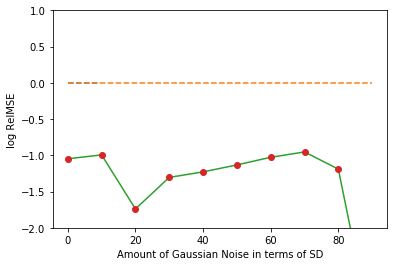

In [13]:
import matplotlib.pyplot as plt
import numpy as np
variance_level_results = np.load("variance_level_results_2.npy")
variance_level_results = variance_level_results.reshape((10,1))
mean_var = np.log(np.mean(variance_level_results,axis=1))
lower_ci = np.log(np.percentile(variance_level_results,q=2.25,axis=1))
upper_ci = np.log(np.percentile(variance_level_results,q=97.5,axis=1))
plt.plot(np.arange(0,100,10),np.repeat(0,10),linestyle='--')
plt.plot(np.arange(0,100,10),mean_var)
plt.plot(np.arange(0,100,10),mean_var,'o')
plt.fill_between(np.arange(0,100,10),lower_ci,upper_ci,alpha=.1)
plt.ylim(-2,1)
plt.xlabel("Amount of Gaussian Noise in terms of SD")
plt.ylabel("log RelMSE")
plt.show()